# On backported updates

In [218]:
import pandas
import numpy as np
import matplotlib
import seaborn

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

from IPython.display import display

%matplotlib inline

In [210]:
FIG_SIZE = (8, 3)
FIG_SIZE_WIDE = (8, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2015-01-01'), pandas.to_datetime('2020-01-01')
CENSOR_DATE = pandas.to_datetime('2020-01-12')

PALETTE = seaborn.color_palette()
PAL_REL = np.take(seaborn.color_palette('muted'), [3, 8, 2, 0], axis=0)
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

# Datasets

## Load data

In [3]:
df_required = dict()
df_dependents = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. required packages')
    df_required[ecosystem] = (
        pandas.read_csv(
            '../data/{}-required.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )
    
    print('.. dependent packages')
    df_dependents[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependents.csv.gz'.format(ecosystem),
        )
    )
    
print('Done!')

Loading Cargo
.. required packages
.. dependent packages
Loading NPM
.. required packages
.. dependent packages
Loading Packagist
.. required packages
.. dependent packages
Loading Rubygems
.. required packages
.. dependent packages
Done!


## Data overview

In [4]:
data = pandas.DataFrame(index=['required', 'releases', 'dependents', 'dependencies'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['required', ecosystem] = len(df_required[ecosystem].drop_duplicates('package'))
    data.at['releases', ecosystem] = len(df_required[ecosystem])
    data.at['dependents', ecosystem] = len(df_dependents[ecosystem].drop_duplicates('source'))
    data.at['dependencies', ecosystem] = len(df_dependents[ecosystem])
    
data

,Cargo,NPM,Packagist,Rubygems
required,1190,15644,2335,715
releases,26344,591812,107912,40219
dependents,13148,247408,36770,11237
dependencies,59901,1069343,93061,23991


In [5]:
data.T[['required', 'releases', 'dependents', 'dependencies']].sum()

required          19884.0
releases         766287.0
dependents       308563.0
dependencies    1246296.0
dtype: float64

Our dependency constraint parsers were able to cope with the large majority of dependency constraints. However, some of them could not be parsed. Let's quantify this. Since the analyses that rely on this preparatory parsing step focus on the latest snapshot of each ecosystem, we only consider this snapshot to quantify this phenomenon.

In [6]:
(
    pandas.concat([
        df_dependents[ecosystem]
        .sort_values('rank')
        .drop_duplicates('source', keep='last')
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index='ecosystem', columns=['c_empty'], values='target', aggfunc='count', margins=True)
    .fillna(0)
    .assign(prop=lambda d: d[True] / d['All'])
)

c_empty,False,True,All,prop
ecosystem,,,,
Cargo,13148.0,0.0,13148,0.000000
NPM,245762.0,1646.0,247408,0.006653
Packagist,35896.0,874.0,36770,0.023769
Rubygems,10560.0,677.0,11237,0.060247
All,305366.0,3197.0,308563,0.010361


# On the need to backport updates to previous major

## Permissivity of dependency constraints

We look at how permissive dependency constraints are, this is, whether they accept patches, minor or major releases. Since we know from previous work that such permissiveness depends on whether the target package is 0.y.z or >=1.0.0, we distinguish these two cases. 

Let's first quantify the number of targets for each category.

In [7]:
ecosystem = 'Cargo'

pandas.concat([
    df_dependents[ecosystem]
    .groupby('c_dev', as_index=False)
    [['target']]
    .count()
    .assign(prop=lambda d: d['target'] / d['target'].sum())
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
).set_index(['ecosystem', 'c_dev'])

target      prop
ecosystem c_dev                  
Cargo     False   21475  0.358508
          True    38426  0.641492
NPM       False  965910  0.903274
          True   103433  0.096726
Packagist False   89750  0.964421
          True     3311  0.035579
Rubygems  False   20821  0.867867
          True     3170  0.132133

In [8]:
data = pandas.concat([
    df_dependents[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['c_patch'] & ~d['c_minor'] & ~d['c_major'],
        minor=lambda d: d['c_minor'] & ~d['c_major'],
        major=lambda d: d['c_major'],
    )
    .pivot_table(index='c_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'c_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

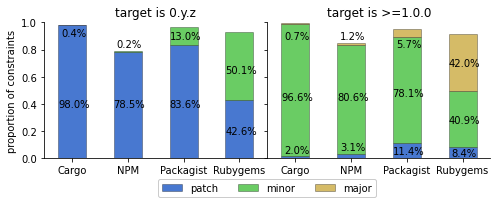

In [9]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

fig.set_size_inches(FIG_SIZE_WIDE)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.92), (0.06, 0.45, 0.90)),
    ((0.40, 0.84), (0.08, 0.45, 0.90)),
    ((0.40, 0.90), (0.05, 0.48, 0.84)),
    ((0.20, 0.65), (0.04, 0.28, 0.70)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i + 0.03, positions[i][j][k]), ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

seaborn.despine(fig, top=True, right=True)

axes[0].set(
    xlabel='',
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'need_permissiveness')

In [10]:
data.T

ecosystem     Cargo                 NPM           Packagist            \
kind        >=1.0.0     0.y.z   >=1.0.0     0.y.z   >=1.0.0     0.y.z   
major      0.006985  0.000000  0.012305  0.000000  0.056669  0.000000   
minor      0.965914  0.003591  0.806013  0.001827  0.781270  0.129568   
patch      0.019744  0.980430  0.031203  0.785301  0.114474  0.836303   

ecosystem  Rubygems            
kind        >=1.0.0     0.y.z  
major      0.420105  0.000000  
minor      0.408818  0.500946  
patch      0.084002  0.426498

As expected, most dependencies (except in Rubygems) are "compliant with semver". That means that, in a situation where they make use of the latest major release of a target package, they will automatically benefit from the latest patch (for 0.y.z) and minor releases (for >=1.0.0).

## Releases being used by dependent packages

However, we expect that not all dependents make use of the latest major of a target package. Let's quantify how many dependents make use of: the latest release, a previous patch, a previous minor or a previous major.

In [11]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'major', 'minor', 'patch']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major', 'minor', 'patch']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    .drop(columns=['package', 'package_selected', 'rank'])
    # Identify release being used
    .eval('''
        latest = major_selected == major and minor_selected == minor and patch_selected == patch
        previous_major = major_selected < major
        previous_minor = major_selected == major and minor_selected < minor
        previous_patch = major_selected == major and minor_selected == minor and patch_selected < patch
    ''')
    .assign(kind=lambda d: d[['latest', 'previous_major', 'previous_minor', 'previous_patch']].idxmax(axis=1))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'kind']]
    for ecosystem in ECOSYSTEMS],
)

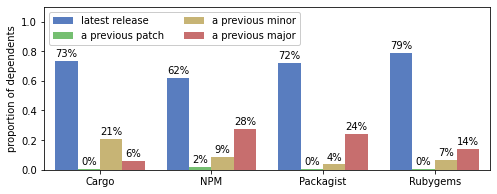

In [12]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(['ecosystem', 'kind'])
    .agg({'source': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'source': 'count'})
    )
    .reset_index()
    .replace({'kind': {'latest': 'latest release', 'previous_major': 'a previous major', 'previous_minor': 'a previous minor', 'previous_patch': 'a previous patch'}})
)

seaborn.barplot(
    x='ecosystem',
    y='source',
    hue='kind',
    hue_order=['latest release', 'a previous patch', 'a previous minor', 'a previous major'],
    order=ECOSYSTEMS,
    data=temp,
    palette=PAL_REL[::-1],
    ax=ax
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate(['latest release', 'a previous patch', 'a previous minor', 'a previous major']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['kind'] == label)].iloc[0].source
        x = i + (j * 0.2 - 0.30)
        ax.annotate('{:.0%}'.format(value), (x, value + 0.05), ha='center', va='center')

ax.legend(ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='proportion of dependents',
    ylim=(0, 1.1),
)

savefig(fig, 'need_used_released')

In [13]:
(
    data
    .groupby(['ecosystem', 'kind'])
    .agg({'source': 'count'})
    # Comment next line for absolute values
    .div(data.groupby('ecosystem').agg({'source': 'count'}))
)

source
ecosystem kind                    
Cargo     latest          0.733942
          previous_major  0.057286
          previous_minor  0.205932
          previous_patch  0.002839
NPM       latest          0.617968
          previous_major  0.275707
          previous_minor  0.086173
          previous_patch  0.020153
Packagist latest          0.717885
          previous_major  0.242196
          previous_minor  0.036182
          previous_patch  0.003738
Rubygems  latest          0.789833
          previous_major  0.137554
          previous_minor  0.067807
          previous_patch  0.004806

## Induced technical lag

Relying on a previous version means that we "lag behind". We quantify this lag, in terms of time (difference between version used and latest version available) and in terms of versions (number of versions that were missed).

In [14]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'rank', 'date']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'date']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    # Ignore up-to-date releases
    [lambda d: d['rank'] != d['selected']]
    .drop(columns=['package', 'package_selected'])
    .assign(timelag=lambda d: d['date'] - d['date_selected'])
    .assign(versionlag=lambda d: d['rank'] - d['selected'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'timelag', 'versionlag']]
    for ecosystem in ECOSYSTEMS],
)

### Time-lag

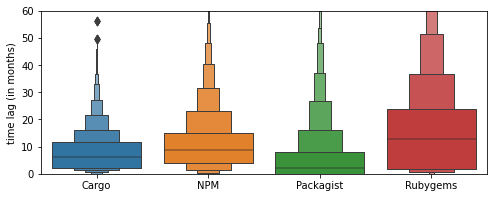

In [15]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='timelag',
    data=data.assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day')),
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='time lag (in months)',
    ylim=(0, 60),
)

savefig(fig, 'need_timelag')

In [16]:
(
    data
    .assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day'))
    .groupby('ecosystem')
    .apply(lambda d: d['timelag'].describe())
)

timelag,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,15554.0,7.554672,10.474680,-60.908777,2.149137,6.341589,11.583088,56.361447
NPM,398211.0,11.209899,12.198101,-81.491625,3.929245,8.733797,14.968530,103.785505
Packagist,25286.0,5.980185,11.912336,-59.578580,0.000780,2.062725,8.192110,101.691821
Rubygems,4767.0,16.643779,18.146921,-28.730652,1.624873,12.970496,23.705577,120.269035


### Version-lag

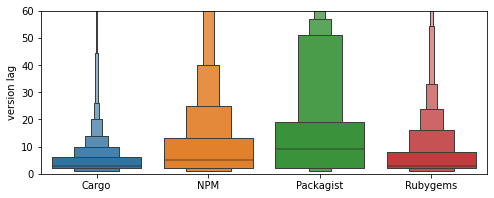

In [17]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='versionlag',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='version lag',
    ylim=(0, 60),
)

savefig(fig, 'need_versionlag')

In [18]:
(
    data
    .groupby('ecosystem')
    .apply(lambda d: d['versionlag'].describe())
)

versionlag,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,15554.0,5.271956,8.333072,1.0,2.0,3.0,6.0,239.0
NPM,398211.0,12.896223,26.609820,1.0,2.0,5.0,13.0,1216.0
Packagist,25286.0,19.211935,34.339034,1.0,2.0,9.0,19.0,872.0
Rubygems,4767.0,9.103000,34.961853,1.0,2.0,3.0,8.0,907.0


## Number of major releases used by dependent packages

Since many dependents make use of a previous major release, let's quantify, given a required package, the number of distinct major being used by dependent packages.

In [38]:
data = pandas.concat([
    df_required[ecosystem]
    # Get the number of distinct major for each package
    .merge(
        df_required[ecosystem]
        .drop_duplicates(['package', 'major'])
        .groupby('package', as_index=False, sort=False)
        .agg({'major': 'count'})
        .rename(columns={'major': 'nb_major'}),
        how='left',
        on='package',
    )
    # Get the number of major used for each package. 
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major']]
        .merge(
            df_dependents[ecosystem]
            [['target', 'selected']],
            how='right',
            left_on=['package', 'rank'],
            right_on=['target', 'selected'],
            suffixes=(None, '_selected'),
        )
        .drop(columns=['target', 'selected'])
        .drop_duplicates(['package', 'major'])
        .groupby('package', sort=False, as_index=False)
        .agg({'major': 'count'})
        .rename(columns={'major': 'used_major'})
    )
    [['package', 'nb_major', 'used_major']]
    .drop_duplicates()
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)

### Number of available major releases

Let's first quantify the number of major releases that are available for each required package.

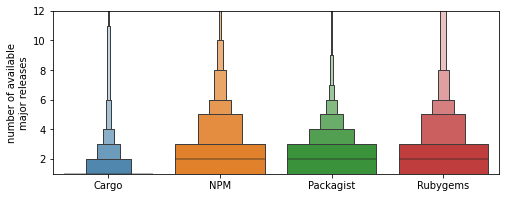

In [20]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='nb_major',
    hue='ecosystem',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    dodge=False,
    ax=ax
)

ax.legend().remove()

ax.set(
    xlabel='',
    ylabel='number of available\nmajor releases',
    ylim=(1, 12),
)

savefig(fig, 'need_number_major_available')

In [21]:
(
    data
    .groupby('ecosystem')
    .apply(lambda d: d['nb_major'].describe())
)

nb_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,1186.0,2.948567,31.320581,1.0,1.0,1.0,1.0,637.0
NPM,15480.0,2.568282,2.657018,1.0,1.0,2.0,3.0,96.0
Packagist,2270.0,2.230396,1.733514,1.0,1.0,2.0,3.0,35.0
Rubygems,714.0,3.144258,5.254016,1.0,1.0,2.0,3.0,54.0


Or, using another way of showing things:

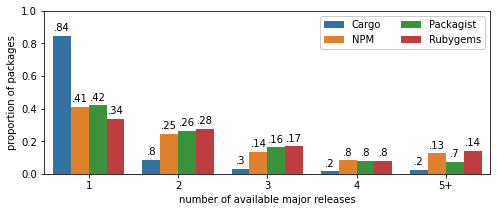

In [22]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .assign(nb_major=lambda d: d['nb_major'].where(d['nb_major'] < 5, '5+'))
    .groupby(['nb_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='nb_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, 4, '5+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['nb_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('.{:.0f}'.format(value*100), (x, value + 0.05), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of available major releases',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_major_available_barplot')

### Number of used major releases

Since 34% to 84% (Cargo!) packages have only a single major version, we only consider packages having at least 2 major releases for the following analyses.

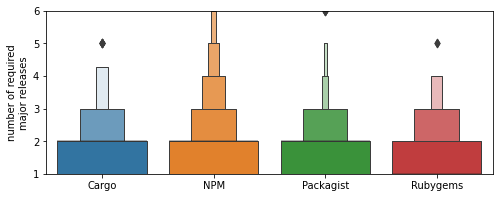

In [23]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='used_major',
    hue='ecosystem',
    data=data[lambda d: d['nb_major'] > 1],
    palette=COLORS,
    hue_order=ECOSYSTEMS,
    dodge=False,
    ax=ax
)

ax.legend().remove()

ax.set(
    xlabel='',
    ylabel='number of required\nmajor releases',
    ylim=(1, 6),
)

savefig(fig, 'need_number_used_major')

In [24]:
(
    data
    [lambda d: d['nb_major'] > 1]
    .groupby('ecosystem')
    .apply(lambda d: d['used_major'].describe())
)

used_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,184.0,1.804348,0.994401,1.0,1.0,2.0,2.0,8.0
NPM,9118.0,2.022373,1.282916,1.0,1.0,2.0,2.0,30.0
Packagist,1319.0,1.736922,0.847075,1.0,1.0,2.0,2.0,7.0
Rubygems,474.0,1.664557,0.816925,1.0,1.0,1.0,2.0,5.0


Again, using a barplot:

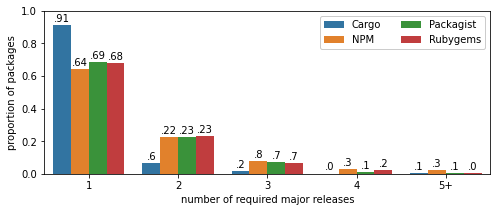

In [25]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 5, '5+'))
    .groupby(['used_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='used_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, 4, '5+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['used_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('.{:.0f}'.format(value*100), (x, value + 0.04), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of required major releases',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_used_major_barplot')

### Proportion of used major releases

Let's do the same, but proportionally to the total number of major releases available. 

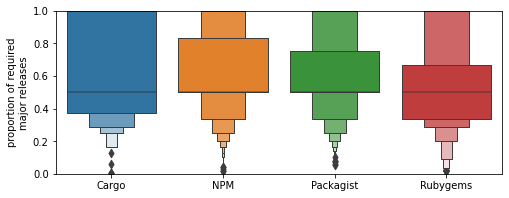

In [40]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='prop_major',
    hue='ecosystem',
    order=ECOSYSTEMS,
    data=data[lambda d: d['nb_major'] > 1].eval('prop_major=used_major / nb_major'),
    palette=COLORS,
    dodge=False,
    ax=ax
)

ax.legend().remove()

ax.set(
    xlabel='',
    ylabel='proportion of required\nmajor releases',
    ylim=(0, 1),
)

savefig(fig, 'need_prop_major')

In [27]:
(
    data
    [lambda d: d['nb_major'] > 1]
    .eval('prop_major=used_major / nb_major')
    .groupby('ecosystem')
    .apply(lambda d: d['prop_major'].describe())
)

prop_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,184.0,0.623521,0.297092,0.003140,0.375000,0.5,1.000000,1.0
NPM,9118.0,0.616194,0.257901,0.016393,0.500000,0.5,0.833333,1.0
Packagist,1319.0,0.608323,0.254845,0.055556,0.500000,0.5,0.750000,1.0
Rubygems,474.0,0.551113,0.264800,0.018519,0.333333,0.5,0.666667,1.0


## Package reuse index

Since a package can have many distinct releases being used by dependent packages, we could propose a "package reuse index" whose goal is to quantify the number of these releases. There are two options there:

1) A variant of a Gini-index, measuring the inequality in terms of "release usage". The more "inequal" this usage is, the more "focused" are dependent packages. However, this does not allow to show whether the "focus" is on the latest major or not. 

2) A variant of the H-index, where n means there are n releases each being used by n dependent packages. 

Let's first compute, for each available major, the number of dependent packages. We'll focus on packages with at least 2 major releases. 

In [41]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count'})
    # Remove packages with a single major
    .groupby('package', as_index=False, sort=False)
    .filter(lambda g: len(g) > 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

### Variant of Gini-index

Let's define a function to compute the Gini value of a numpy array. 

Taken from https://github.com/oliviaguest/gini

1 = inequality; 0 = equality.

In [29]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

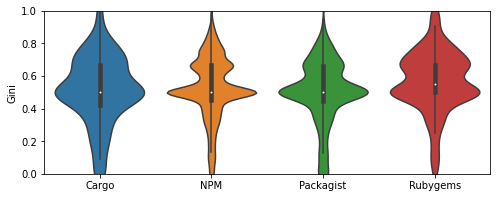

In [94]:
fix, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='source',
    hue='ecosystem',
    order=ECOSYSTEMS,
    data=(
        data
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg({'source': lambda s: gini(s.to_numpy(dtype='float64'))})
    ),
    dodge=False,
    palette=COLORS,
    ax=ax
)

ax.legend().remove()

ax.set(
    xlabel='',
    ylabel='Gini',
    ylim=(0, 1),
)

savefig(fig, 'index_gini')

In [31]:
(
    data
    .groupby(['ecosystem', 'package'], as_index=False)
    .agg(gini=('source', lambda s: gini(s.to_numpy(dtype='float64'))))
    .groupby('ecosystem')
    .apply(lambda g: g.gini.describe())
)

gini,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,184.0,0.513157,0.208198,0.0,0.422709,0.50000,0.666667,0.998030
NPM,9157.0,0.526651,0.184491,0.0,0.452381,0.50000,0.666667,0.983606
Packagist,1353.0,0.502962,0.190432,0.0,0.444444,0.50000,0.658730,0.944444
Rubygems,474.0,0.567051,0.185414,0.0,0.500000,0.54759,0.666667,0.981481


One can expect a relation between the number of dependents, available majors, required majors, and the Gini value...

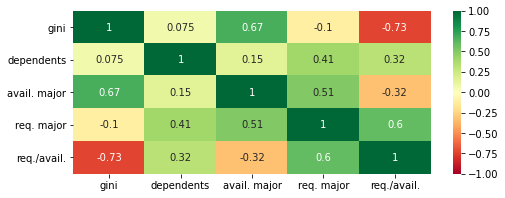

In [100]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(used_major=lambda d: d['source'] > 0)
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg(
            gini=('source', lambda s: gini(s.to_numpy(dtype='float64'))),
            dependents=('source', 'sum'),
            major=('major', 'count'),
            used_major=('used_major', 'sum')
        )
        .eval('ratio_major = used_major / major')
        [['gini', 'dependents', 'major', 'used_major', 'ratio_major']]
        .rename(columns={
            'gini': 'gini',
            'dependents': 'dependents',
            'major': 'avail. major',
            'used_major': 'req. major',
            'ratio_major': 'req./avail.'
        })
        .corr('spearman')
    ),
    vmin=-1,
    vmax=1,
    cmap='RdYlGn',
    annot=True,
    ax=ax,
)

savefig(fig, 'index_gini_corr')

### Variant of H-index

Let's first define a function that computes it.

In [89]:
def x_index(values):
    for i, d in enumerate(sorted(values, reverse=True)):
        if i + 1 >= d:
            #return max(d, 10e-5)
            return i + 1
    return i + 1

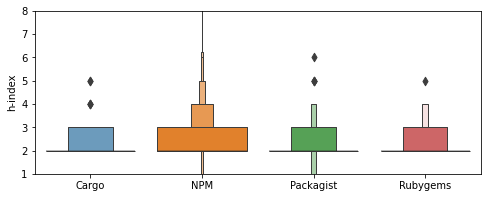

In [95]:
fix, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='source',
    hue='ecosystem',
    order=ECOSYSTEMS,
    data=(
        data
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg({'source': x_index})
    ),
    dodge=False,
    palette=COLORS,
    ax=ax
)

ax.legend().remove()

ax.set(
    xlabel='',
    ylabel='h-index',
    ylim=(1, 8),
)

savefig(fig, 'index_h')

In [96]:
(
    data
    .groupby(['ecosystem', 'package'], as_index=False)
    .agg({'source': x_index})
    .groupby('ecosystem').apply(lambda g: g.source.describe())
)

source,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,184.0,2.201087,0.509794,2.0,2.0,2.0,2.0,5.0
NPM,9157.0,2.395435,0.824028,1.0,2.0,2.0,3.0,14.0
Packagist,1353.0,2.212860,0.541677,1.0,2.0,2.0,2.0,6.0
Rubygems,474.0,2.189873,0.452644,2.0,2.0,2.0,2.0,5.0


Is there any correlation with previously considered characteristics?

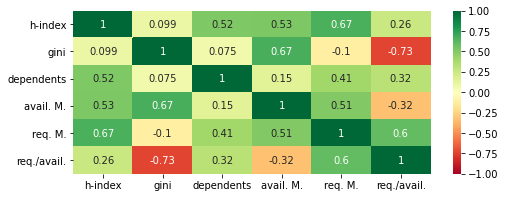

In [104]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(used_major=lambda d: d['source'] > 0)
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg(
            h_index=('source', x_index),
            gini=('source', lambda s: gini(s.to_numpy(dtype='float64'))),
            dependents=('source', 'sum'),
            major=('major', 'count'),
            used_major=('used_major', 'sum')
        )
        .eval('ratio_major = used_major / major')
        [['h_index', 'gini', 'dependents', 'major', 'used_major', 'ratio_major']]
        .rename(columns={
            'gini': 'gini',
            'dependents': 'dependents',
            'h_index': 'h-index',
            'major': 'avail. M.',
            'used_major': 'req. M.',
            'ratio_major': 'req./avail.'
        })
        .corr('spearman')
    ),
    vmin=-1,
    vmax=1,
    cmap='RdYlGn',
    annot=True,
    ax=ax,
)

savefig(fig, 'index_h_corr')

# On the prevalence of backported updates

## Evolution of the number of packages with backports

In [124]:
data = pandas.concat([
    df_required[ecosystem]
    # First release
    [lambda d: d['rank'] == 1]
    [['date']]
    .assign(created=1)
    # First backport, if any
    .merge(
        df_required[ecosystem]
        [lambda d: d['backported']]
        .drop_duplicates('package', keep='first')
        [['date']]
        .assign(backported=1),
        how='outer',
        on='date'
    )
    .fillna(0)
    .set_index('date')
    .sort_index()
    .cumsum()
    .assign(prop=lambda d: d['backported'] / d['created'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)

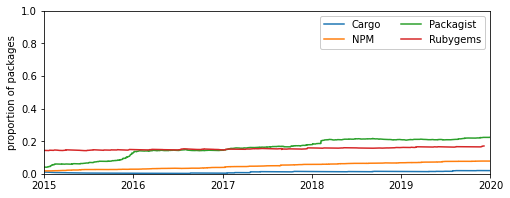

In [136]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.lineplot(
    x='date',
    y='prop',
    hue='ecosystem',
    data=data,
    palette=COLORS,
    hue_order=ECOSYSTEMS,
    ci=None,  # speed-up
    ax=ax
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'prev_prop_packages')

In [138]:
(
    data
    .groupby('ecosystem')
    .last()
)

,created,backported,prop
ecosystem,,,
Cargo,1190.0,23.0,0.019328
NPM,15646.0,1228.0,0.078487
Packagist,2335.0,518.0,0.221842
Rubygems,715.0,122.0,0.170629


## Proportion of backported releases for packages with backports

In [146]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby('package', as_index=False, sort=False)
    .agg({
        'version': 'count',
        'backported': 'sum',
    })
    # Remove packages with no backport
    [lambda d: d['backported'] > 0]
    .assign(prop=lambda d: d['backported'] / d['version'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

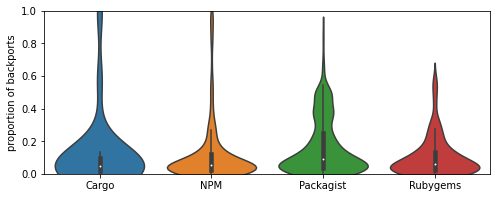

In [151]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='prop',
    hue='ecosystem',
    dodge=False,
    data=data,
    order=ECOSYSTEMS,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.legend().remove()

ax.set(
    xlabel='',
    ylabel='proportion of backports',
    ylim=(0, 1),
)

savefig(fig, 'prev_prop_releases')

In [149]:
(
    data
    .groupby('ecosystem')
    .apply(lambda g: g['prop'].describe())
)

prop,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,23.0,0.117966,0.224624,0.004878,0.019189,0.044944,0.097222,0.983333
NPM,1226.0,0.120338,0.187833,0.000663,0.023810,0.051392,0.121981,0.990909
Packagist,518.0,0.166276,0.169280,0.003155,0.035877,0.090909,0.250000,0.866667
Rubygems,122.0,0.106820,0.123422,0.006024,0.023339,0.057190,0.132509,0.586592


## Relation between backports and dependents

We see whether there is relation between the presence of backports and the number of dependent packages.

In [193]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

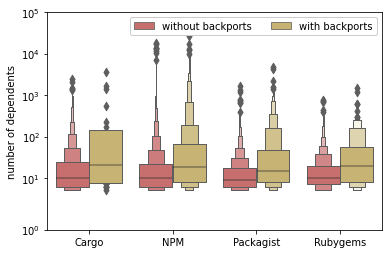

In [194]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='dependents',
    hue='backports',
    data=(
        data
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    ylabel='number of dependents',
    yscale='symlog',
    ylim=(1, 10e4),
)

savefig(fig, 'prev_backport_dependents')

In [195]:
(
    data
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['dependents']].describe())
    .unstack()
)

dependents                                     \
                                 count        mean          std  min  25%   
ecosystem backports                                                         
Cargo     with backports          23.0  351.086957   838.074520  5.0  7.5   
          without backports     1167.0   44.409597   157.456210  5.0  6.0   
NPM       with backports        1226.0  254.790375  1259.544375  5.0  8.0   
          without backports    14418.0   52.501734   381.568644  5.0  6.0   
Packagist with backports         518.0  100.972973   352.618982  5.0  8.0   
          without backports     1817.0   22.430930    73.284408  5.0  6.0   
Rubygems  with backports         122.0   79.229508   191.011046  5.0  8.0   
          without backports      593.0   24.156830    60.828270  5.0  7.0   

                                                    
                              50%     75%      max  
ecosystem backports                                 
Cargo     with backports     21.0  146.00   3647.0  
          without backports  10.0   24.00   2466.0  
NPM       with backports     18.0   65.50  26163.0  
          without backports  10.0   22.00  18354.0  
Packagist with backports     15.0   48.00   4844.0  
          without backports   9.0   17.00   1648.0  
Rubygems  with backports     19.5   54.75   1469.0  
          without backports  10.0   19.00    756.0

Is there a statistical difference between these distributions?

In [196]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0)].dependents
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0)].dependents
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.01159; d=0.275 (small)
NPM        with vs. without: p=0.00000; d=0.281 (small)
Packagist  with vs. without: p=0.00000; d=0.313 (small)
Rubygems   with vs. without: p=0.00000; d=0.279 (small)


## Relation between backports and used major

We see whether there is a relation between the presence of backports and the number of major releases being used.

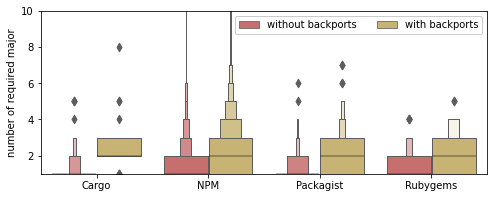

In [217]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='used_major',
    hue='backports',
    data=(
        data
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    ylabel='number of required major',
    ylim=(1, 10),
)

savefig(fig, 'prev_backport_used_major')

In [200]:
(
    data
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)

used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
Cargo     with backports          23.0  2.521739  1.647852  1.0  2.0  2.0   
          without backports     1167.0  1.093402  0.393798  0.0  1.0  1.0   
NPM       with backports        1226.0  2.434747  1.591631  0.0  1.0  2.0   
          without backports    14418.0  1.513178  1.029360  0.0  1.0  1.0   
Packagist with backports         518.0  2.098456  0.969535  0.0  1.0  2.0   
          without backports     1817.0  1.186021  0.551891  0.0  1.0  1.0   
Rubygems  with backports         122.0  2.032787  1.043947  1.0  1.0  2.0   
          without backports      593.0  1.317032  0.587594  0.0  1.0  1.0   

                                        
                             75%   max  
ecosystem backports                     
Cargo     with backports     3.0   8.0  
          without backports  1.0   5.0  
NPM       with backports     3.0  15.0  
          without backports  2.0  30.0  
Packagist with backports     3.0   7.0  
          without backports  1.0   6.0  
Rubygems  with backports     3.0   5.0  
          without backports  2.0   4.0

In [201]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0)].used_major
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0)].used_major
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=0.721 (large)
NPM        with vs. without: p=0.00000; d=0.431 (medium)
Packagist  with vs. without: p=0.00000; d=0.580 (large)
Rubygems   with vs. without: p=0.00000; d=0.403 (medium)


Can we suspect any other correlation? 

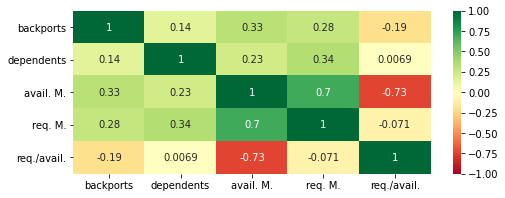

In [216]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        [['backports', 'dependents', 'major', 'used_major']]
        .eval('ratio_major = used_major / major')
        .rename(columns={
            'major': 'avail. M.',
            'used_major': 'req. M.',
            'ratio_major': 'req./avail.'
        })
        .corr('spearman')
    ),
    vmin=-1,
    vmax=1,
    cmap='RdYlGn',
    annot=True,
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

savefig(fig, 'prev_correlation')

# How and when are releases backported?

## Backport release type

The type of a backport depends on the "source" release (the one being backported) and the "target" release (the one being the backport). We expect that most backports correspond to patches being backported as patches, but it could be the case that some minor release has its fixes being backported as patch as well.

## Time and number of versions w.r.t. first `(N+1).x.x`

We expect that most backports are "quickly" released when a new major is available, in order to allow security or stability fixes to be available for dependents during their transition to the new major. 

## Time and number of versions w.r.t. first `(N).x.x`

Here we merely look at how long major versions are "supported". This aims to confirm that major releases having backports have more a "long-term support" than major releases without backports.

## Time and number of versions w.r.t. last (N).x.x

Same idea, but this time relatively to the latest (non-backported) release in the current branch.